# COIN-OR Makespan

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
from collections import defaultdict

import time

In [2]:
basic_data_path = get_path("data", "basic")

In [3]:
df_jssp = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [4]:
df_times = pd.read_csv(basic_data_path / "00_arrivals.csv")
df_times  

,Job,Arrival
0,job 5,83.59
1,job 8,107.22
2,job 7,125.26
3,job 0,181.45
4,job 4,270.56
5,job 9,309.13
6,job 3,586.13
7,job 2,667.09
8,job 1,713.06
9,job 6,747.96


In [5]:
def solve_jssp_makespan_with_arrival(df_jssp: pd.DataFrame, df_arrivals: pd.DataFrame, solver: str = 'CBC', 
                                     epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert den Makespan eines Job-Shop-Problems mit Ankunftszeiten.

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals: DataFrame mit ['Job','Arrival'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - time_limit: Max. Zeit in Sekunden für den Solver.
    - epsilon: Pufferzeit in Minuten zwischen zwei Jobs auf derselben Maschine.
    - sort_ascending: Sortierung der Jobs nach Ankunft (True = früh zuerst).
    - **solver_args: Weitere Solver-Parameter wie msg=True, threads=4 etc.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Machine',
      'Start','Processing Time','Flow time','End'].
    """

    # 1. Vorverarbeitung
    df_arrivals = df_arrivals.sort_values("Arrival", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals.set_index("Job")["Arrival"].to_dict()
    jobs = df_arrivals["Job"].tolist()

    # BigM berechnen (Worst Case)
    sum_proc_time = df_jssp["Processing Time"].sum()

    min_arrival = min(arrival.values())
    max_arrival = max(arrival.values())

    bigM_raw = max_arrival - min_arrival + sum_proc_time
    bigM = math.ceil(bigM_raw * 1.4 / 1000) * 1000
    # bigM = 1e5
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops = []
    machines = set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. LP-Modell
    prob = pulp.LpProblem("JSSP_Makespan_Arrival", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    makespan = pulp.LpVariable("makespan", lowBound=0)
    prob += makespan

    # 4. Technologische Reihenfolge
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

        # Makespan ≥ Endzeit letzte OP
        d_last = seq[-1][2]
        prob += makespan >= starts[(j, len(seq) - 1)] + d_last

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solver auswählen
    solver_args.setdefault("msg", True)

    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    makespan_value = pulp.value(prob.objective)

    # 7. Ergebnisse extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "Flow time": round(ed - arrival[job], 2),
                "End": round(ed, 2)
            })

    df_schedule = (
        pd.DataFrame(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Makespan                : {round(makespan_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [6]:
max_time = 60*60*8 # 4h

### a) CBC - COIN-OR Branch and Cut

In [7]:
starting_time = time.time()

# Scheduling
df_plan = solve_jssp_makespan_with_arrival(df_jssp, df_times, solver= "CBC", msg=False, timeLimit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 9000

Solver-Informationen:
  Makespan                : 1346.13
  Solver-Status           : Optimal
  Anzahl Variablen        : 551
  Anzahl Constraints      : 1000

Scheduling-Dauer: 0 Minuten und 2.74 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 5,0,83.59,M2,83.59,84.0,84.00,167.59
1,job 8,0,107.22,M0,107.22,76.0,76.00,183.22
2,job 5,1,83.59,M1,167.59,2.0,86.00,169.59
3,job 5,2,83.59,M5,169.59,52.0,138.00,221.59
4,job 0,0,181.45,M0,183.22,29.0,30.77,212.22
...,...,...,...,...,...,...,...,...
95,job 1,9,713.06,M8,1261.13,30.0,578.07,1291.13
96,job 6,8,747.96,M7,1261.13,30.0,543.17,1291.13
97,job 3,8,586.13,M9,1281.13,22.0,717.00,1303.13
98,job 6,9,747.96,M4,1291.13,55.0,598.17,1346.13


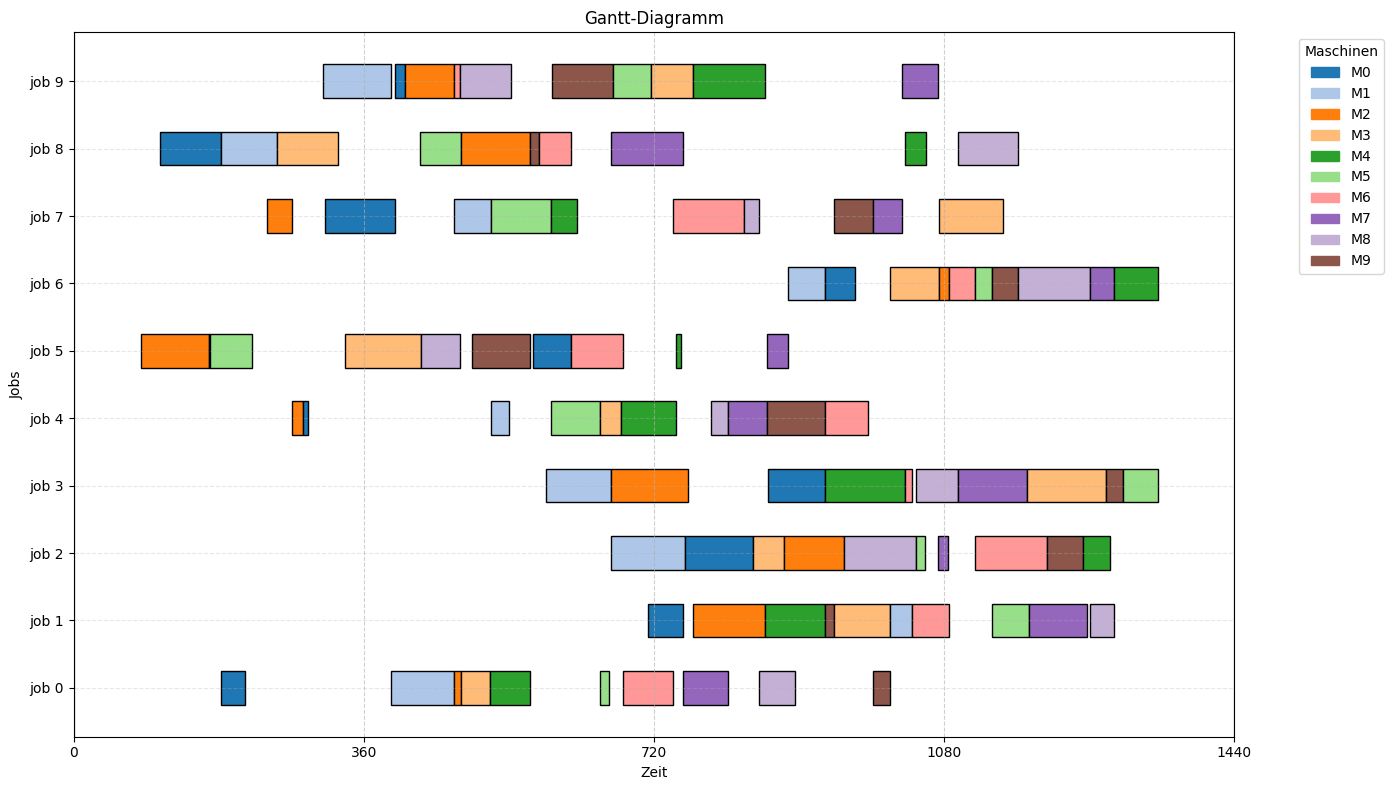

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [8]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

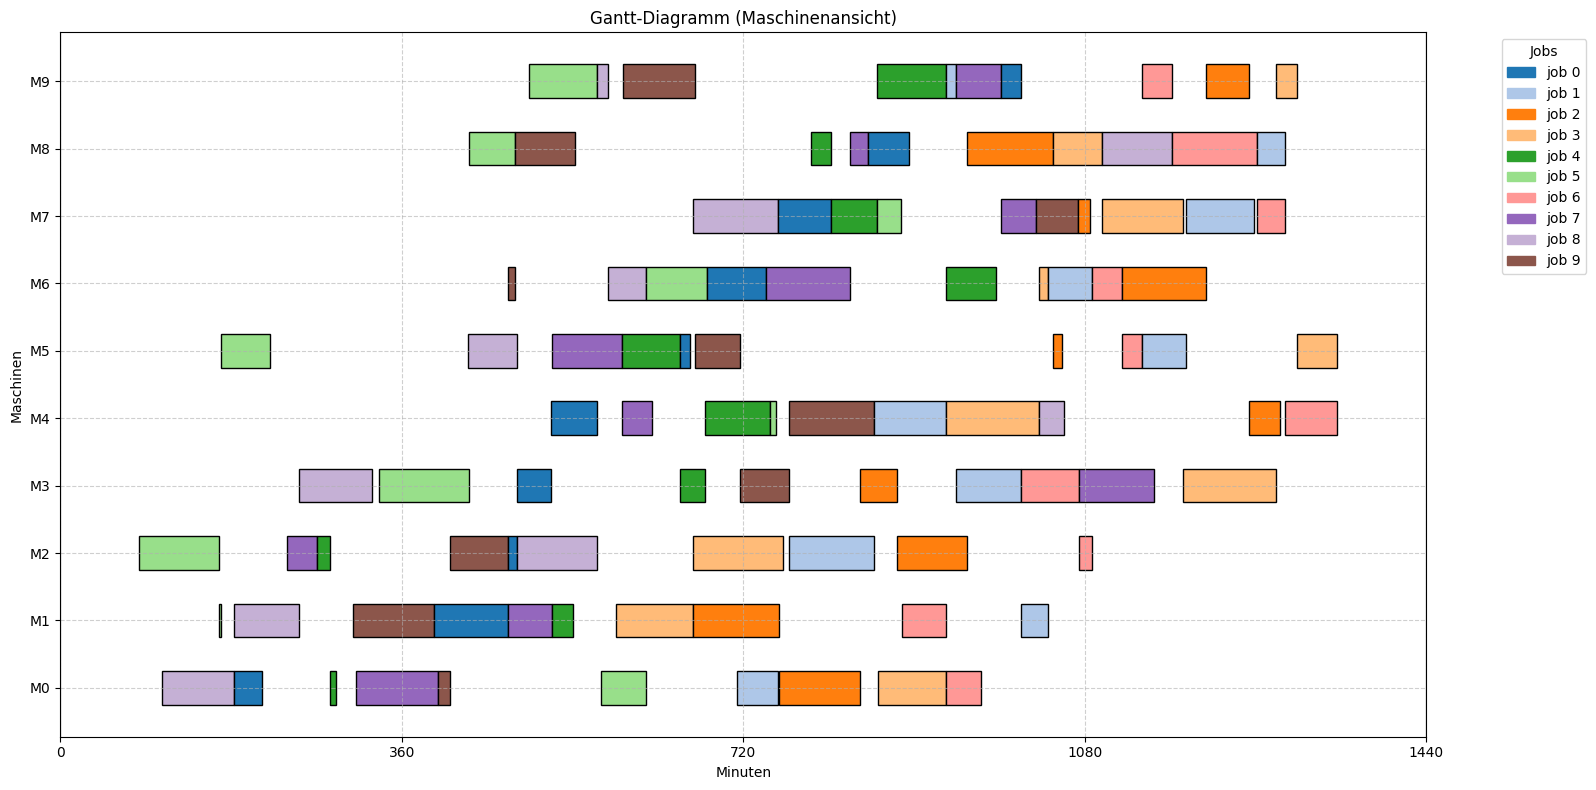

In [9]:
show.plot_gantt_machines(df_plan)

### b) HiGHS mit PuLP

In [10]:
starting_time = time.time()

# Scheduling
df_plan = solve_jssp_makespan_with_arrival(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, threads = 6)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.1f} Sekunden.")
df_plan

BigM: 9000

Solver-Informationen:
  Makespan                : 1346.13
  Solver-Status           : Optimal
  Anzahl Variablen        : 551
  Anzahl Constraints      : 1000

Scheduling-Dauer: 0 Minuten und 4.5 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 8,0,107.22,M0,107.22,76.0,76.00,183.22
1,job 7,0,125.26,M2,125.26,31.0,31.00,156.26
2,job 5,0,83.59,M2,156.26,84.0,156.67,240.26
3,job 7,1,125.26,M0,183.22,86.0,143.96,269.22
4,job 8,1,107.22,M1,183.22,69.0,145.00,252.22
...,...,...,...,...,...,...,...,...
95,job 1,9,713.06,M8,1261.13,30.0,578.07,1291.13
96,job 6,8,747.96,M7,1261.13,30.0,543.17,1291.13
97,job 3,8,586.13,M9,1281.13,22.0,717.00,1303.13
98,job 6,9,747.96,M4,1291.13,55.0,598.17,1346.13


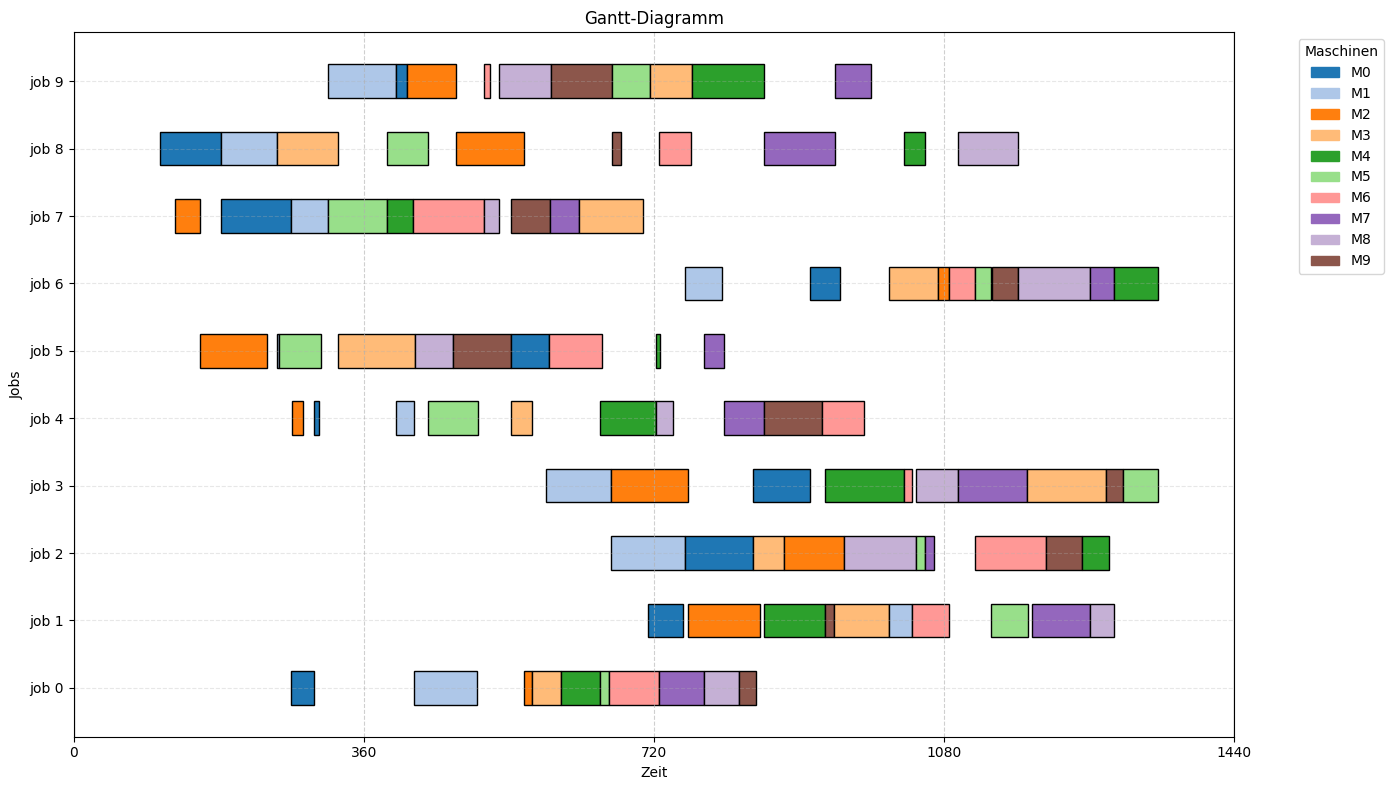

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [11]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)